### Importing Required Libraries

In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import nltk
from nltk.stem import WordNetLemmatizer
from gensim.models import Word2Vec

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import re # for regex
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize,sent_tokenize
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB,MultinomialNB,BernoulliNB
from sklearn.metrics import accuracy_score
import pickle
import string
from sklearn.metrics import classification_report,confusion_matrix
from imblearn.over_sampling import SMOTE


/usr/local/lib/python3.7/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)


In [8]:
# import nltk
# nltk.download('all')

In [9]:
from google.colab import files
uploaded = files.upload()

Saving amazon_headphones.csv to amazon_headphones.csv
Saving amazon_home_theater.csv to amazon_home_theater.csv
Saving amazon_laptops.csv to amazon_laptops.csv
Saving amazon_monitors.csv to amazon_monitors.csv
Saving amazon_phones.csv to amazon_phones.csv
Saving amazon_printers.csv to amazon_printers.csv
Saving amazon_professional_cameras.csv to amazon_professional_cameras.csv
Saving amazon_router.csv to amazon_router.csv
Saving amazon_smart_watches.csv to amazon_smart_watches.csv
Saving flip_headphones.csv to flip_headphones.csv
Saving flip_hometheater.csv to flip_hometheater.csv
Saving flip_laptops.csv to flip_laptops.csv
Saving flip_monitors.csv to flip_monitors.csv
Saving flip_phones.csv to flip_phones.csv
Saving flip_printers.csv to flip_printers.csv
Saving flip_professional_cameras.csv to flip_professional_cameras.csv
Saving flip_router.csv to flip_router.csv
Saving flip_smartwatches.csv to flip_smartwatches.csv


### Reading all datasets

In [10]:
lap=pd.read_csv('amazon_laptops.csv')
headphone=pd.read_csv('amazon_headphones.csv')
home_theater=pd.read_csv('amazon_home_theater.csv')
professional_cameras=pd.read_csv('amazon_professional_cameras.csv')
router=pd.read_csv('amazon_router.csv')
monitors=pd.read_csv('amazon_monitors.csv')
phones=pd.read_csv('amazon_phones.csv')
printers=pd.read_csv('amazon_printers.csv')
smart_watches=pd.read_csv('amazon_smart_watches.csv')

flip_smart_watches=pd.read_csv('flip_smartwatches.csv')
flip_router=pd.read_csv('flip_router.csv')
flip_professional_cameras=pd.read_csv('flip_professional_cameras.csv')
flip_printers=pd.read_csv('flip_printers.csv')
flip_phones=pd.read_csv('flip_phones.csv')
flip_monitors=pd.read_csv('flip_monitors.csv')
flip_hometheater=pd.read_csv('flip_hometheater.csv')
flip_headphones=pd.read_csv('flip_headphones.csv')
flip_laptops=pd.read_csv('flip_laptops.csv')

### Concatinating all dataframe's into one data frame and removing unwanted columns and null values

In [11]:
df=pd.concat([lap,headphone,home_theater,professional_cameras,router,monitors,phones,printers,smart_watches,flip_smart_watches,
              flip_router,flip_professional_cameras,flip_printers,flip_phones,flip_monitors,flip_hometheater,flip_headphones,flip_laptops]).reset_index(drop=True)
df.drop(['Unnamed: 0'],axis=1,inplace=True)
df["Merged_review"]=df['Rating_heading']+" "+df['Reviews']
df.drop(['Rating_heading','Reviews'],axis=1,inplace=True)

rating_lis=[]
for i in df['Rating']:
    try:
      rating_lis.append(round(float(i.split()[0])))
    except:
      rating_lis.append(int(i))

df['Rating']=rating_lis

df.dropna(axis=0,inplace=True)

### Shape of data set after merging all data sets

In [12]:
df.shape

(119516, 2)

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


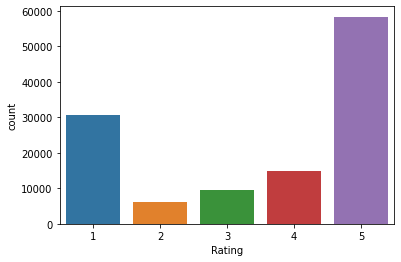

In [13]:
sns.countplot(df['Rating'])

In [8]:
df['Rating'].value_counts()

5    58341
1    30792
4    14904
3     9466
2     6013
Name: Rating, dtype: int64

### Creating new dataframe and balacing the same data

In [14]:
df1=df[df['Rating']==5][:10000]
df2=df[df['Rating']==4][:10000]
df3=df[df['Rating']==3][:]
df4=df[df['Rating']==2][:]
df5=df[df['Rating']==1][:10000]
blnc_df=pd.concat([df1,df2,df3,df4,df5])
print(blnc_df.shape)
blnc_df['Rating'].value_counts()

(45479, 2)


5    10000
4    10000
1    10000
3     9466
2     6013
Name: Rating, dtype: int64

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


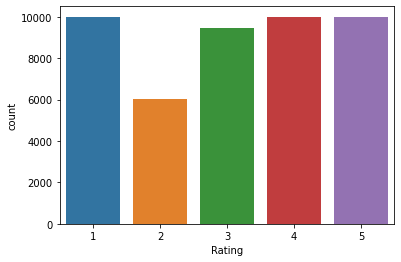

In [15]:
sns.countplot(blnc_df['Rating'])

In [16]:
df['Review_length_before_clean']=df['Merged_review'].str.len()

In [29]:
# Cleaning Data functions

def removing_email_address(text):
    return text.replace(r'^.+@[^\.].*\.[a-z]{2,}$','')

def removing_emojis(text):
    return text.encode('ascii', 'ignore').decode('ascii')

def clean(text):
    cleaned = re.compile(r'<.*?>')
    return re.sub(cleaned,'',text) # substring replace with ''(space)

def is_special(text):
    rem = ''
    for i in text:
        if i.isalnum():
            rem = rem + i
        else:
            rem = rem + ' '
    return rem

def to_lower(text):
    return text.lower()

def removing_phone_number(text):
    return text.replace(r'^\(?[\d]{3}\)?[\s-]?[\d]{3}[\s-]?[\d]{4}$','')

def remove_numbers(text):
    return re.sub(r'\d','',text)

def remove_word_less_than_2(text):
    return [w for w in text.split() if len(w)>2]

def rem_stopwords(text):
    stop_words = set(stopwords.words('english') + ['u', 'ü', 'ur', '4', '2', 'im', 'doin', 'ure'])
    return [w for w in text if w not in stop_words]

def stem_txt(text):
    lemma_words=[]
    for word in text:
        word = WordNetLemmatizer().lemmatize(word,pos='v')
        lemma_words.append(word)
    return ' '.join(lemma_words)

# TFIDF Vectorizer
def tfidf_vect(Merged_review):
    tfid = TfidfVectorizer(smooth_idf=True)
    X = tfid.fit_transform(Merged_review).toarray()
    print("X.shape = ",X.shape)
    print("y.shape = ",y.shape)
    tfidf_bow=tfid.vocabulary_
    
    return X,tfidf_bow

# Count Vectorizer
def cv_vect(Merged_review):
    cv = CountVectorizer()
    X = cv.fit_transform(Merged_review).toarray()
    print("X.shape = ",X.shape)
    print("y.shape = ",y.shape)
    cv_bow=cv.vocabulary_
    
    return X,cv_bow


# For finding best random State
def best_rn_state(model,X,target):
    best_state=0
    accu=0
    for i in range(50,120):
        X_train, X_test, y_train, y_test = train_test_split(X,target, test_size=0.25,random_state=i)
        md = model
        md.fit(X_train,y_train)
        pred = md.predict(X_test)
        rscrore=accuracy_score(y_test,pred)
        if rscrore>accu:
            accu=rscrore
            best_state=i
    return best_state


# Testing Model manually
def test_data(text,bag_w,model,shape):
    rem_email=removing_email_address(text)
    rem_emoji=removing_emojis(rem_email)
    cln=clean(rem_emoji)
    isspecial=is_special(cln)
    tolower=to_lower(isspecial)
    removing_phonenumber=removing_phone_number(tolower)
    removenumbers=remove_numbers(removing_phonenumber)
    remove_word_lessthan2=remove_word_less_than_2(removenumbers)
    remstopwords=rem_stopwords(remove_word_lessthan2)
    stemtxt=stem_txt(remstopwords)
    bow,words = [],word_tokenize(stemtxt)
    for word in words:
        bow.append(words.count(word))

    inp = []
    for i in bag_w:
        inp.append(stemtxt.count(i[0]))
    y_pred = model.predict(np.array(inp).reshape(1,shape))
    return y_pred[0]

# Accuracy metrix
def accuracy_reports(testy,pred):
    print(classification_report(testy,pred))
    conf_mat=confusion_matrix(testy,pred)
    print("*****************************")
    print(conf_mat)
    plt.figure(figsize=(12,8))
    sns.heatmap(conf_mat,annot=True)
    plt.show()
    


In [20]:
lis=[]
for text in df['Merged_review']:
    rem_email=removing_email_address(text)
    rem_emoji=removing_emojis(rem_email)
    cln=clean(rem_emoji)
    isspecial=is_special(cln)
    tolower=to_lower(isspecial)
    removing_phonenumber=removing_phone_number(tolower)
    removenumbers=remove_numbers(removing_phonenumber)
    remove_word_lessthan2=remove_word_less_than_2(removenumbers)
    remstopwords=rem_stopwords(remove_word_lessthan2)
    stemtxt=stem_txt(remstopwords)
    lis.append(stemtxt)
df['Clean_review']=lis

In [21]:
df['Review_length_after_clean']=df['Clean_review'].str.len()

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function 

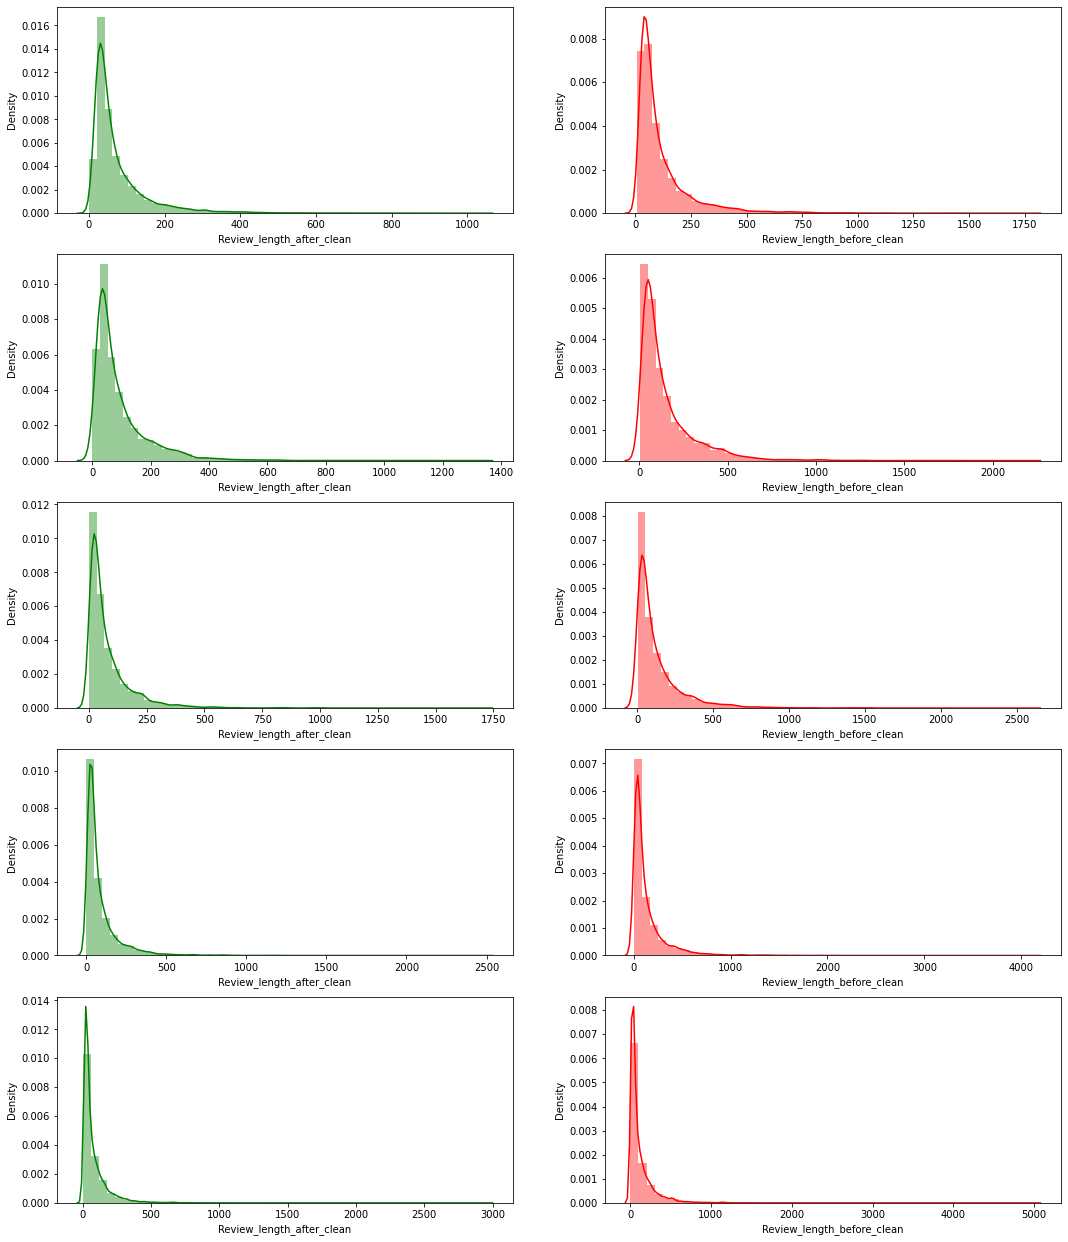

In [22]:
# Message distribution AFTER cleaning
f,ax = plt.subplots(5,2,figsize = (18,22))
sns.distplot(df[df['Rating']==1]['Review_length_after_clean'],bins=50,ax=ax[0][0],label='Review after cleaning distribution Ratinng=1',color='g')
sns.distplot(df[df['Rating']==1]['Review_length_before_clean'],bins=50,ax=ax[0][1],label='Review before cleaning distribution Ratinng=1',color='r')

sns.distplot(df[df['Rating']==2]['Review_length_after_clean'],bins=50,ax=ax[1][0],label='Review after cleaning distribution Ratinng=2',color='g')
sns.distplot(df[df['Rating']==2]['Review_length_before_clean'],bins=50,ax=ax[1][1],label='Review before cleaning distribution Ratinng=2',color='r')

sns.distplot(df[df['Rating']==3]['Review_length_after_clean'],bins=50,ax=ax[2][0],label='Review after cleaning distribution Ratinng=3',color='g')
sns.distplot(df[df['Rating']==3]['Review_length_before_clean'],bins=50,ax=ax[2][1],label='Review before cleaning distribution Ratinng=3',color='r')

sns.distplot(df[df['Rating']==4]['Review_length_after_clean'],bins=50,ax=ax[3][0],label='Review after cleaning distribution Ratinng=4',color='g')
sns.distplot(df[df['Rating']==4]['Review_length_before_clean'],bins=50,ax=ax[3][1],label='Review before cleaning distribution Ratinng=4',color='r')

sns.distplot(df[df['Rating']==5]['Review_length_after_clean'],bins=50,ax=ax[4][0],label='Review after cleaning distribution Ratinng=5',color='g')
sns.distplot(df[df['Rating']==5]['Review_length_before_clean'],bins=50,ax=ax[4][1],label='Review before cleaning distribution Ratinng=5',color='r')


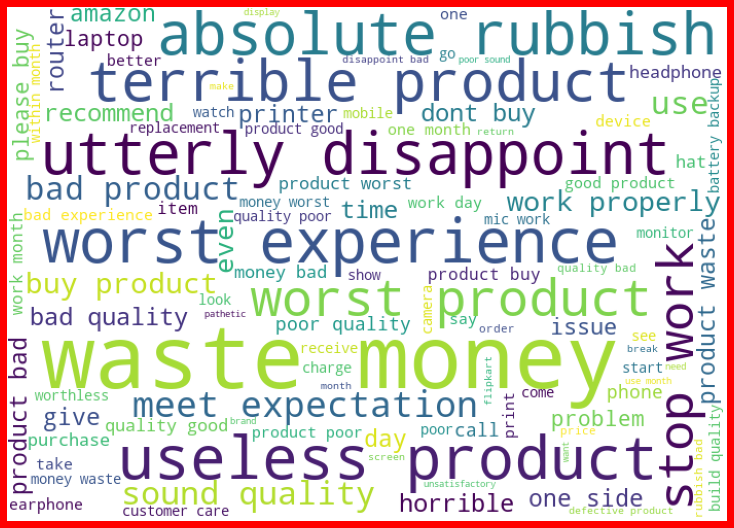

In [ ]:
#Getting sense of loud words in spam 
from wordcloud import WordCloud


spams = df['Clean_review'][df['Rating']==1]

spam_cloud = WordCloud(width=700,height=500,background_color='white',max_words=100).generate(' '.join(spams))

plt.figure(figsize=(10,8),facecolor='r')
plt.imshow(spam_cloud)
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()

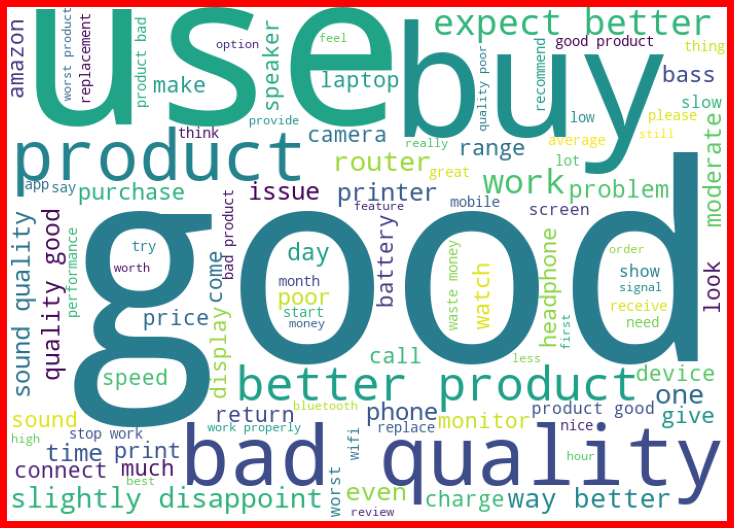

In [ ]:
spams = df['Clean_review'][df['Rating']==2]

spam_cloud = WordCloud(width=700,height=500,background_color='white',max_words=100).generate(' '.join(spams))

plt.figure(figsize=(10,8),facecolor='r')
plt.imshow(spam_cloud)
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()

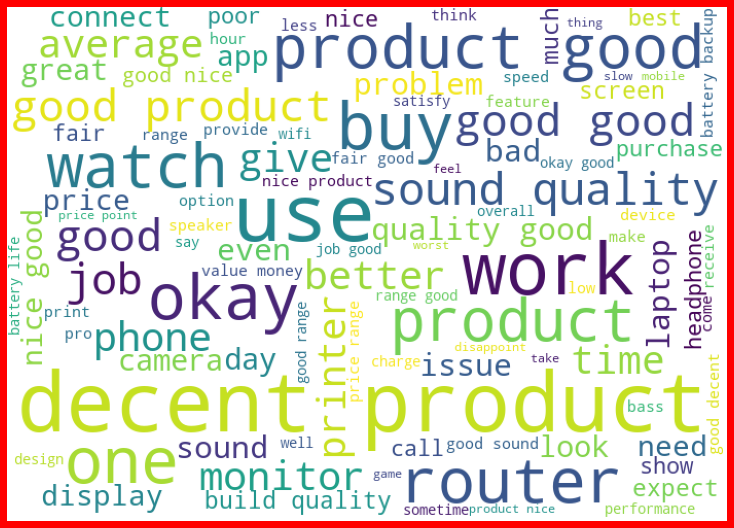

In [ ]:
spams = df['Clean_review'][df['Rating']==3]

spam_cloud = WordCloud(width=700,height=500,background_color='white',max_words=100).generate(' '.join(spams))

plt.figure(figsize=(10,8),facecolor='r')
plt.imshow(spam_cloud)
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()

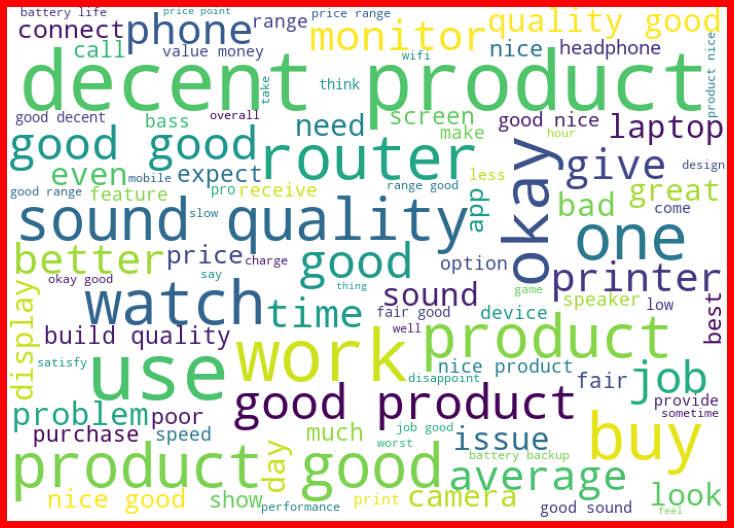

In [ ]:
spams = df['Clean_review'][df['Rating']==3]

spam_cloud = WordCloud(width=700,height=500,background_color='white',max_words=100).generate(' '.join(spams))

plt.figure(figsize=(10,8),facecolor='r')
plt.imshow(spam_cloud)
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()

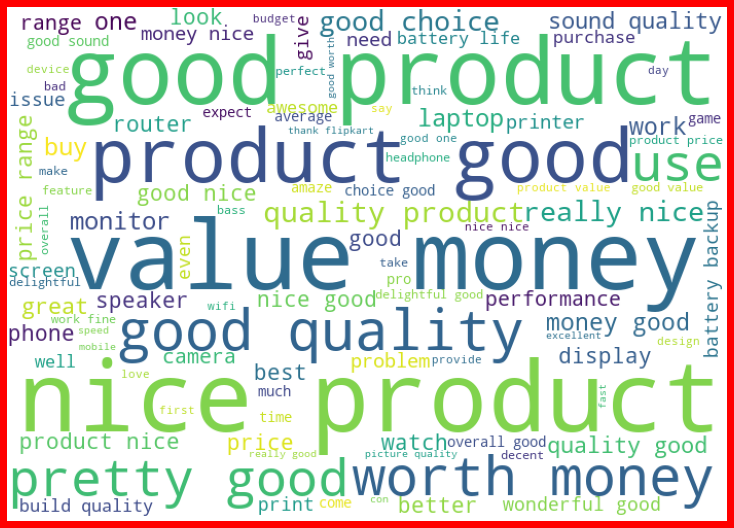

In [ ]:
spams = df['Clean_review'][df['Rating']==4]

spam_cloud = WordCloud(width=700,height=500,background_color='white',max_words=100).generate(' '.join(spams))

plt.figure(figsize=(10,8),facecolor='r')
plt.imshow(spam_cloud)
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()

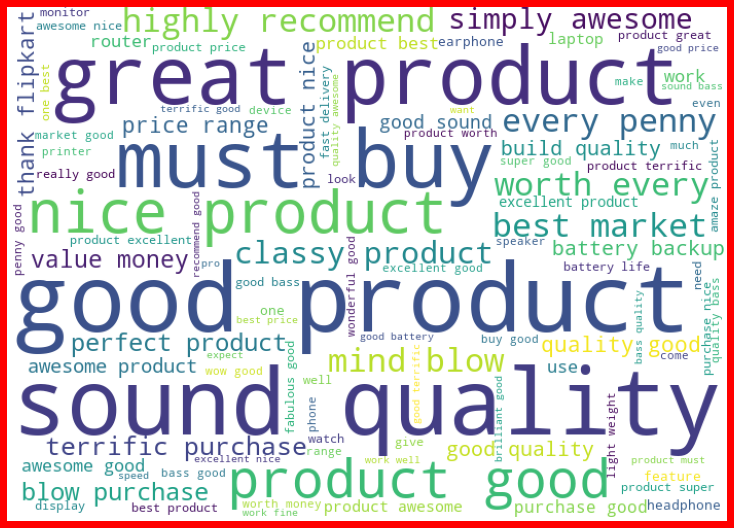

In [ ]:
spams = df['Clean_review'][df['Rating']==5]

spam_cloud = WordCloud(width=700,height=500,background_color='white',max_words=100).generate(' '.join(spams))

plt.figure(figsize=(10,8),facecolor='r')
plt.imshow(spam_cloud)
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()

In [ ]:
df['Review_length_before_clean'].max()

5015

In [ ]:
df['Review_length_after_clean'].max()

2962

### Taking sample data from original Data

In [23]:
sample_df=df.sample(35000)

### Models

In [24]:

# seperating lable and target  column on sample data

X = np.array(sample_df['Clean_review'].values)
y = np.array(sample_df["Rating"].values)

In [18]:
tf_X,tf_bow=tfidf_vect(sample_df['Clean_review'])

X.shape =  (35000, 10973)
y.shape =  (35000,)


In [26]:
cv_X,cv_bow=cv_vect(sample_df['Clean_review'])

X.shape =  (35000, 10996)
y.shape =  (35000,)


In [19]:
# best_rn_state(MultinomialNB(alpha=0.1,fit_prior=True),tf_X,y)

In [18]:
# 2. Train test split
trainx,testx,trainy,testy = train_test_split(tf_X,y,test_size=0.3,random_state=109)
print("Train shapes : X = {}, y = {}".format(trainx.shape,trainy.shape))
print("Test shapes : X = {}, y = {}".format(testx.shape,testy.shape))


Train shapes : X = (24500, 10940), y = (24500,)
Test shapes : X = (10500, 10940), y = (10500,)


In [20]:
tf_mnb = MultinomialNB(alpha=0.1,fit_prior=True)
tf_mnb.fit(trainx,trainy)
tf_p = tf_mnb.predict(testx)

print("Training Score = ",tf_mnb.score(trainx,trainy))
print("Multinomial = ",   accuracy_score(testy,tf_p))


Training Score =  0.8522448979591837
Multinomial =  0.7906666666666666


In [17]:
# 2. Train test split
trainx,testx,trainy,testy = train_test_split(cv_X,y,test_size=0.3,random_state=109)
print("Train shapes : X = {}, y = {}".format(trainx.shape,trainy.shape))
print("Test shapes : X = {}, y = {}".format(testx.shape,testy.shape))


Train shapes : X = (24500, 11106), y = (24500,)
Test shapes : X = (10500, 11106), y = (10500,)


In [20]:
cv_mnb = MultinomialNB(alpha=0.1,fit_prior=True)
cv_mnb.fit(trainx,trainy)
cv_p = cv_mnb.predict(testx)

print("Training Score = ",cv_mnb.score(trainx,trainy))
print("Multinomial = ",   accuracy_score(testy,cv_p))


Training Score =  0.8588979591836735
Multinomial =  0.796


In [36]:
sample_df[sample_df['Rating']==4]['Clean_review']

39137                                        wonderful nice
44849                                      value money good
38698                                        wonderful good
98059                                      worth money best
81943                       pretty good super video quality
                                ...                        
37058                              good choice good product
28667                                         good good use
56733     pretty good nice printer print quality excelle...
20102     nice one nice product help wife keep follow wo...
119284    nice product unit overall good issue performan...
Name: Clean_review, Length: 4410, dtype: object

In [32]:
test_data(sample_df[sample_df['Rating']==1]['Clean_review'][19932],cv_bow,cv_mnb,10896)

2

In [1]:
test_data(sample_df[sample_df['Rating']==1]['Clean_review'][19932],tf_bow,tf_mnb,10896)

In [25]:
from sklearn.ensemble import RandomForestClassifier

In [ ]:
rfc=RandomForestClassifier(n_estimators=300)
# 2. Train test split
trainx,testx,trainy,testy = train_test_split(cv_X,y,test_size=0.3,random_state=109)
print("Train shapes : X = {}, y = {}".format(trainx.shape,trainy.shape))
print("Test shapes : X = {}, y = {}".format(testx.shape,testy.shape))

rfc.fit(trainx,trainy)
rfc_p = rfc.predict(testx)

print("Training Score = ",rfc.score(trainx,trainy))
print("Random Forest = ",   accuracy_score(testy,rfc_p))


In [20]:
rf=RandomForestClassifier(n_estimators=300)
# 2. Train test split
trainx,testx,trainy,testy = train_test_split(tf_X,y,test_size=0.3,random_state=109)
print("Train shapes : X = {}, y = {}".format(trainx.shape,trainy.shape))
print("Test shapes : X = {}, y = {}".format(testx.shape,testy.shape))

rf.fit(trainx,trainy)
rf_p = rf.predict(testx)

print("Training Score = ",rf.score(trainx,trainy))
print("Random Forest = ",   accuracy_score(testy,rf_p))


Train shapes : X = (24500, 10973), y = (24500,)
Test shapes : X = (10500, 10973), y = (10500,)
Training Score =  0.9897959183673469
Random Forest =  0.8583809523809524


In [39]:
test_data(sample_df[sample_df['Rating']==4]['Clean_review'][37058],tf_bow,rf,10973)

1

In [27]:
rfc=RandomForestClassifier(n_estimators=300)
# 2. Train test split
trainx,testx,trainy,testy = train_test_split(cv_X,y,test_size=0.3,random_state=109)
print("Train shapes : X = {}, y = {}".format(trainx.shape,trainy.shape))
print("Test shapes : X = {}, y = {}".format(testx.shape,testy.shape))

rfc.fit(trainx,trainy)
rf_p = rfc.predict(testx)

print("Training Score = ",rfc.score(trainx,trainy))
print("Random Forest = ",   accuracy_score(testy,rf_p))


Train shapes : X = (24500, 10996), y = (24500,)
Test shapes : X = (10500, 10996), y = (10500,)
Training Score =  0.9885306122448979
Random Forest =  0.8628571428571429


In [41]:
test_data(sample_df[sample_df['Rating']==3]['Clean_review'][8044],cv_bow,rfc,10996)

5

              precision    recall  f1-score   support

           1       0.87      0.96      0.91      2666
           2       0.87      0.46      0.60       530
           3       0.76      0.56      0.65       863
           4       0.79      0.60      0.68      1268
           5       0.88      0.97      0.92      5173

    accuracy                           0.86     10500
   macro avg       0.84      0.71      0.75     10500
weighted avg       0.86      0.86      0.85     10500

*****************************
[[2566   10   20   10   60]
 [ 164  242   39   21   64]
 [ 140   10  487   74  152]
 [  45   11   62  755  395]
 [  32    4   36   91 5010]]


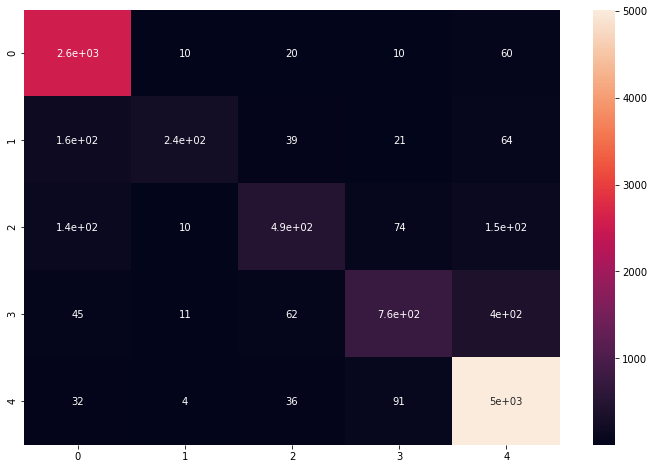

In [30]:
accuracy_reports(testy,rf_p)

In [39]:
sample_df[sample_df['Rating']==3]['Clean_review']

46535    fair happy receive first dslr life till work s...
23852                                     fair worth price
14762    phone worth money charger cable hard seem old ...
22335    fair expect like beta version still lot featur...
88276                              job sound quality goods
                               ...                        
5009           best low budget gamers like nice low budget
43322                                    fair good product
7160                                hay fine fine set work
37484                                            nice good
8044     good good good brand satisfy sound quality som...
Name: Clean_review, Length: 2770, dtype: object

In [43]:
pickle.dump(rfc,open('rating_model.pkl','wb'))

In [44]:
pickle.dump(cv_bow,open('rating_bow.pkl','wb'))